<ipython-input-3-9910c6f28f4b>:24: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0029
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5813e-04
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5615e-04
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1503e-04
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9365e-04
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.2812e-04
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.6946e-04
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7034e-04
Epoch 9/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5465e-04
Epoch 10/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7554e-04
Epoch 11/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3900e-04
Epoch 12/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3159e-04
Epoch 13/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1455e-04
Epoch 14/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1350e-04
Epoch 15/50
11

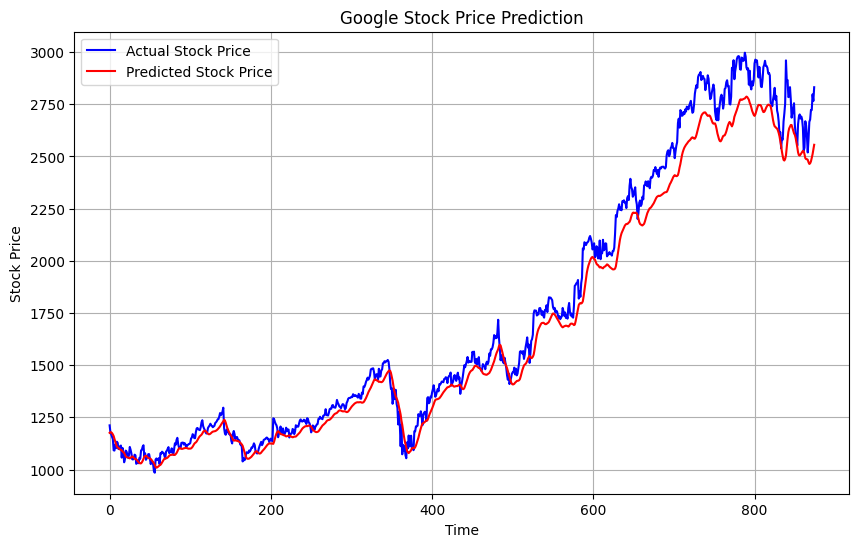

In [3]:
# Install necessary package if not already installed:
# pip install kagglehub[pandas-datasets]

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Function: load_and_preprocess_data
def load_and_preprocess_data():
    """
    Load stock price data from KaggleHub and normalize the 'Close' column.

    Returns:
        scaled_data (np.array): Normalized values of the 'Close' price.
        scaler (MinMaxScaler): Fitted scaler object (for inverse transform
        later).
    """
    file_path = "GOOGL.csv"
    df = kagglehub.load_dataset(
        KaggleDatasetAdapter.PANDAS,
        "varpit94/google-stock-data",
        file_path
    )
    data = df[['Close']].values

    # Normalize data to the range [0,1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    return scaled_data, scaler

# Function: create_time_windows
def create_time_windows(data, window_size):
    """
    Convert the time series data into a set of time windows (input sequences)
    and corresponding targets.

    Parameters:
        data (np.array): The scaled time series data.
        window_size (int): The number of past time steps to use as input.

    Returns:
        X (np.array): Input sequences with shape (samples, window_size,
         features).
        y (np.array): Target values corresponding to each input sequence.
    """
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])

    # Convert lists to numpy arrays and reshape
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y

# Function: build_lstm_model
def build_lstm_model(input_shape):
    """
    Build and return an LSTM based time series forecasting model.

    Hyperparameters explained:
    - LSTM units: 50 units to capture temporal patterns.
    - Dropout: 20% to prevent overfitting.
    - Dense layer: Single neuron for the final prediction.

    Parameters:
        input_shape (tuple): Shape of the input data (timesteps, features).

    Returns:
        model (tf.keras.Model): Compiled LSTM forecasting model.
    """
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function: plot_predictions
def plot_predictions(test_data, predictions, title="Stock Price Prediction"):
    """
    Plot the actual stock prices vs the predicted stock prices.

    Parameters:
        test_data (np.array): The actual stock prices.
        predictions (np.array): Predicted stock prices.
        title (str): Title for the plot.
    """
    plt.figure(figsize=(10,6))
    plt.plot(test_data, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid()
    plt.show()

# Main execution block
if __name__ == "__main__":
    np.random.seed(42)  # Set random seed for reproducibility

    # Load and preprocess the data
    scaled_data, scaler = load_and_preprocess_data()

    # Create input-output sequences
    window_size = 60
    X, y = create_time_windows(scaled_data, window_size)

    # Split the data into training and testing sets
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]

    # Build and compile the model
    model = build_lstm_model((X_train.shape[1], 1))

    # Define early stopping callback
    early_stop = EarlyStopping(monitor='loss', patience=5)

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1,
              callbacks=[early_stop])

    # Predict and inverse transform
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot the results
    plot_predictions(actual_prices, predictions, title="Google Stock Price
    Prediction")